In [1]:
import csv
import dataset_loader
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import function
import similarity

from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import train_test_split

from typing import List, Tuple

from tqdm import tqdm

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"
# DATASET_ROOT="../../sabana/dataset/newbie-dataset"

In [3]:
SLICE_DURATION = 5 # sec
EXPANSION_RATE = 1.5
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 500
QUEUE_SIZE = 8
ONSET_WEIGHT = 10.0
SETTLE_FRAME = 10
COMPENSATION_FRAME = 0

SAVE_ROOT = pathlib.Path("./save")

if not SAVE_ROOT.exists():
    SAVE_ROOT.mkdir(exist_ok=True, parents=True)


In [4]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, slice_duration=SLICE_DURATION, expansion_rate=EXPANSION_RATE, frame_per_second=FRAME_PER_SECOND, shuffle=True)

pos_similarities: List[Tuple[float, float, float]] = []
neg_similarities: List[Tuple[float, float, float]] = []

prev_perfs: List[np.ndarray] = [None] * QUEUE_SIZE

In [5]:
decay_fn = function.get_decay_fn("exponential", SETTLE_FRAME)
unit_metric = function.get_unit_metric("onset_nearest", SETTLE_FRAME, COMPENSATION_FRAME)
distance_metric = function.default_distance

In [6]:
with open(SAVE_ROOT / "pos.csv", "w", encoding="utf-8") as f1, \
     open(SAVE_ROOT / "neg.csv", "w", encoding="utf-8") as f2:
    pos_csvfile = csv.writer(f1, delimiter=",", quotechar="|")
    pos_csvfile.writerow(["Euclidean Similarity", "Timewarping Similarity", "Length ratio"])

    neg_csvfile = csv.writer(f2, delimiter=",", quotechar="|")
    neg_csvfile.writerow(["Euclidean Similarity", "Timewarping Similarity", "Length ratio"])

    for idx in tqdm(range(NUM_SAMPLES)):
        score, perf, _ = gen.__next__()
        score_len = score.shape[-1]
        perf_len = perf.shape[-1]

        pos_euclidean_similarity, pos_timewarping_similarity = similarity.score_similarity(score, perf,
                                                                                                    onset_weight=ONSET_WEIGHT,
                                                                                                    decay_fn=decay_fn,
                                                                                                    unit_metric=unit_metric,
                                                                                                    distance_metric=distance_metric)
        pos_length_ratio = perf_len / (score_len + 1e-7)

        pos_csvfile.writerow([pos_euclidean_similarity, pos_timewarping_similarity, pos_length_ratio])
        pos_similarities.append((pos_euclidean_similarity, pos_timewarping_similarity, pos_length_ratio))
        
        if isinstance(prev_perfs[0], np.ndarray):
            prev_perf = prev_perfs[0]
            prev_perf_len = prev_perf.shape[-1]
            neg_euclidean_similarity, neg_timewarping_similarity = similarity.score_similarity(score, prev_perf,
                                                                                            onset_weight=ONSET_WEIGHT,
                                                                                            decay_fn=decay_fn,
                                                                                            unit_metric=unit_metric,
                                                                                            distance_metric=distance_metric) 
            neg_length_ratio = prev_perf_len / (score_len + 1e-7)
            
            neg_csvfile.writerow([neg_euclidean_similarity, neg_timewarping_similarity, neg_length_ratio])
            neg_similarities.append((neg_euclidean_similarity, neg_timewarping_similarity, neg_length_ratio))
        prev_perfs.pop(0)
        prev_perfs.append(perf)

 38%|███▊      | 192/500 [01:41<03:03,  1.68it/s]/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_on channel=0 note=65 velocity=0 time=41.872395833333336
  warnings.warn('ignoring MIDI message %s' % msg)
 46%|████▌     | 228/500 [02:10<04:23,  1.03it/s]/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_off channel=0 note=77 velocity=64 time=100.4978125
  warnings.warn('ignoring MIDI message %s' % msg)
/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_off channel=0 note=67 velocity=60 time=155.47718750000095
  warnings.warn('ignoring MIDI message %s' % msg)
/home/kaparoo/anaconda3/envs/tensorflow23_py36/lib/python3.6/site-packages/madmom/io/midi.py:366: UserWarning: ignoring MIDI message note_off channel=0 note=79 velocity=52 t

In [7]:
pos_similarities = np.array(pos_similarities)
neg_similarities = np.array(neg_similarities)
print(pos_similarities.shape)
print(neg_similarities.shape)

(500, 3)
(492, 3)


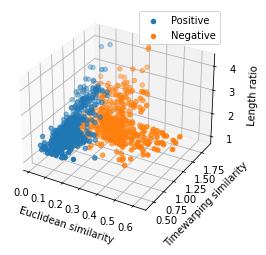

<Figure size 432x288 with 0 Axes>

In [8]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.set_xlabel("Euclidean similarity")
ax.set_ylabel("Timewarping similarity")
ax.set_zlabel("Length ratio")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], pos_similarities[:,2], label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], neg_similarities[:,2], label="Negative")
plt.legend()
plt.show()

plt.clf()

In [9]:
x_total = np.concatenate([pos_similarities, neg_similarities])
y_total = np.array([+1 for _ in range(len(pos_similarities))] + [-1 for _ in range(len(neg_similarities))])
print(x_total.shape)
print(y_total.shape)


(992, 3)
(992,)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=0.2, stratify=y_total, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(793, 3)
(793,)
(199, 3)
(199,)


In [11]:
svm_linear = SVC(kernel="linear")
svm_linear.fit(x_train, y_train)
print("Accuracy:", svm_linear.score(x_test, y_test))

Accuracy: 0.949748743718593


In [16]:
svm_poly3 = SVC(kernel="poly", degree=3)
svm_poly3.fit(x_train, y_train)
print("Accuracy:", svm_poly3.score(x_test, y_test))

Accuracy: 0.9597989949748744


In [17]:
svm_poly5 = SVC(kernel="poly", degree=5)
svm_poly5.fit(x_train, y_train)
print("Accuracy:", svm_poly5.score(x_test, y_test))

Accuracy: 0.949748743718593


In [18]:
svm_poly7 = SVC(kernel="poly", degree=7)
svm_poly7.fit(x_train, y_train)
print("Accuracy:", svm_poly7.score(x_test, y_test))

Accuracy: 0.9547738693467337


In [39]:
svm_rbf = SVC(kernel="rbf")
svm_rbf.fit(x_train, y_train)
print("Accuracy:", svm_rbf.score(x_test, y_test))

Accuracy: 0.9547738693467337


In [34]:
svm_linear_ = SVC(kernel="linear")
svm_linear_.fit(x_train[:, :2], y_train)

SVC(kernel='linear')

In [37]:
svm_linear_.coef_, svm_linear_.intercept_

(array([[-7.54869355, -3.07975157]]), array([4.6549425]))

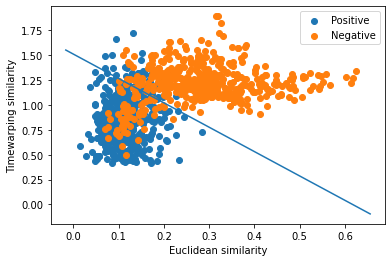

<Figure size 432x288 with 0 Axes>

In [45]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Euclidean similarity")
ax.set_ylabel("Timewarping similarity")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], label="Negative")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_ = np.linspace(xlim[0], xlim[1])
y_ =  -(svm_linear_.coef_[0][0]*x_ + svm_linear_.intercept_[0])/svm_linear_.coef_[0][1]

ax.plot(x_, y_)

plt.legend()
plt.show()

plt.clf()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

100%|██████████| 98/98 [00:00<00:00, 161.83it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


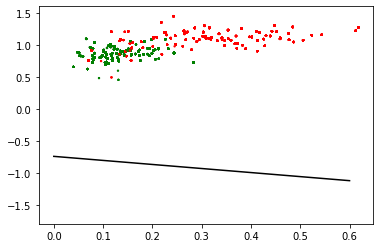

In [55]:
# num_frames = min(len(pos_similarities), len(neg_similarities))
num_frames = 100

fig, ax = plt.subplots()

ims = []
for i in tqdm(range(2, num_frames)):
    pos_sub = pos_similarities[:i]
    neg_sub = neg_similarities[:i]

    x_sub = np.concatenate([pos_sub, neg_sub])
    y_sub = np.array([+1 for _ in range(len(pos_sub))] + [-1 for _ in range(len(neg_sub))])
    

    svm = SVC(kernel="linear")
    svm.fit(x_sub, y_sub)
    
    xlim_ = ax.get_xlim()
    w = svm.coef_[0]           # w consists of 2 elements
    b = svm.intercept_[0]
    x_ = np.linspace(0.0, 0.6)
    y_ = -(w[0] * x_ - b) / w[1]

    im1 = ax.scatter(pos_sub[:, 0], pos_sub[:, 1], pos_sub[:, 2], 'g', label="positive")
    im1 = ax.scatter(neg_sub[:, 0], neg_sub[:, 1], neg_sub[:, 2], 'r', label="negative")
    im1 = ax.plot(x_, y_, "k", label="decision_boundary")
    ims.append(im1)

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save(SAVE_ROOT / 'ani.gif', writer='imagemagick')
plt.show()

In [63]:
num_frames = min(len(pos_similarities), len(neg_similarities))
svm_argv = {"kernel": "linear"}

with open(SAVE_ROOT / "svm.csv", "w", encoding="utf-8") as f:
    svm_csvfile = csv.writer(f, delimiter=",", quotechar="|")
    svm_csvfile.writerow(["coef_x", "ceof_y", "bias"])
    for i in tqdm(range(3, num_frames)):
        pos_sub = pos_similarities[:i]
        neg_sub = neg_similarities[:i]

        x_sub = np.concatenate([pos_sub, neg_sub])
        y_sub = np.array([+1 for _ in range(len(pos_sub))] + [-1 for _ in range(len(neg_sub))])

        svc = SVC(**svm_argv)
        svc.fit(x_sub, y_sub)

        coef_x = svc.coef_[0][0] / svc.coef_[0][2]
        coef_y = svc.coef_[0][1] / svc.coef_[0][2]
        bias   = svc.intercept_[0] / svc.coef_[0][2]


        svm_csvfile.writerow([coef_x, coef_y, bias])

100%|██████████| 489/489 [00:01<00:00, 268.35it/s]
